# Preprocessing

(copied from Test_Tri_Poler_Regridding.ipynb)

In [1]:
%matplotlib inline
import xarray as xr
import xesmf
import os
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import seaborn as sns
import esio
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

#os.chdir('/home/disk/sipn/nicway/python/regrid')

gfdl_grid_file = r'GFDLFLOR_gridinfo.nc' # Correct GFDL grid info
gfdl_grid = esio.load_grid_info(gfdl_grid_file, model='GFDL')
ds_in = xr.open_dataset('sic_OImon_GFDL-FLORB01_FLORB01-P1-ECDA-v3.1-122012_r7i1p1_201212-201311.nc')

stero_grid_file = r'stereo_gridinfo.nc'
ds_target = esio.load_grid_info(stero_grid_file, 'NSIDC')
ds_target['lat_b'] = ds_target.lat_b.where(ds_target.lat_b < 90, other = 90)

In [2]:
# Add N+1 coords
ds_in.rename({'lat':'nj', 'lon':'ni'}, inplace=True);
ds_in.coords['nj'] = gfdl_grid.nj
ds_in.coords['ni'] = gfdl_grid.ni
ds_in.coords['lat'] = gfdl_grid.lat
ds_in.coords['lon'] = gfdl_grid.lon
ds_in.coords['lat_b'] = gfdl_grid.lat_b
ds_in.coords['lon_b'] = gfdl_grid.lon_b
ds_in = ds_in.sum(dim='ct').isel(time=0)

In [3]:
ds_in

<xarray.Dataset>
Dimensions:     (bnds: 2, ni: 360, ni_b: 361, nj: 200, nj_b: 201)
Coordinates:
  * bnds        (bnds) float64 1.0 2.0
    time        datetime64[ns] 2012-12-16T12:00:00
  * ni          (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * nj          (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    lat         (nj, ni) float64 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 ...
    lon         (nj, ni) float64 -279.5 -278.5 -277.5 -276.5 -275.5 -274.5 ...
  * nj_b        (nj_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * ni_b        (ni_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    lat_b       (nj_b, ni_b) float64 -81.0 -81.0 -81.0 -81.0 -81.0 -81.0 ...
    lon_b       (nj_b, ni_b) float64 -280.0 -279.0 -278.0 -277.0 -276.0 ...
Data variables:
    sic         (nj, ni) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    average_DT  timedelta64[ns] ...
    average_T1  datetime64[ns] ...
    average_T

# Check source data structure

## Plot source grid data

In [4]:
def polar_axis():
    '''cartopy geoaxes centered at north pole'''
    plt.figure(figsize=(6, 5))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax.coastlines(linewidth=0.75, color='black', resolution='50m')
    ax.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    return ax

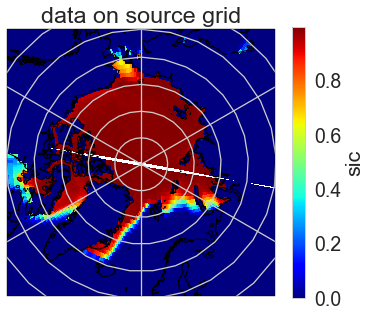

In [5]:
# Note that the "seam" is already missing in the source data itself!
# See below for why
ax = polar_axis() 
ds_in['sic'].plot.pcolormesh(ax=ax, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(), cmap='jet')
plt.title('data on source grid')

## Scatter grid points

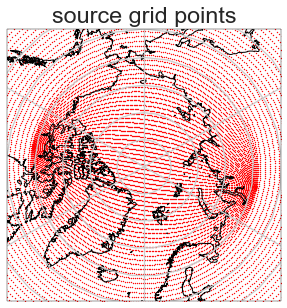

In [6]:
# the source grid has two separate tiles
# the entire array is not a legal "quadrilateral grid"
# need to break up
ax = polar_axis() 
ax.scatter(ds_in['lon'], ds_in['lat'], 
            transform=ccrs.PlateCarree(), s=1.0, c='r')
plt.title('source grid points')

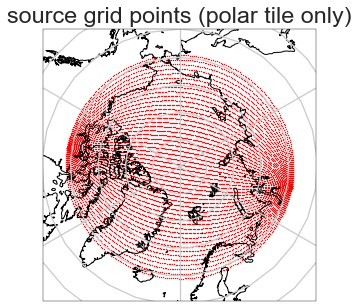

In [7]:
# Only show the polar tile
# The left bound 175 is just a rough estimate.
ax = polar_axis() 
ax.scatter(ds_in['lon'][175:, :], ds_in['lat'][175:, :], 
            transform=ccrs.PlateCarree(), s=1.0, c='r')
plt.title('source grid points (polar tile only)')

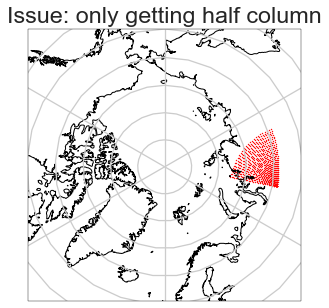

In [8]:
# The above figure looks like a normal, single-tile 2D grid, 
# but it is actually not. The grid layout is very weird. 

# By slicing the first 30 elements in the second dimension,
# I expect to get the first 30 complete colums.
# But in fact I only get half columns
ax = polar_axis() 
ax.scatter(ds_in['lon'][175:, :30], ds_in['lat'][175:, :30], 
            transform=ccrs.PlateCarree(), s=1.0, c='r')
plt.title('Issue: only getting half column')

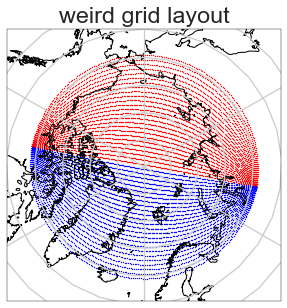

In [9]:
# By increasing the index of the second dimension, the grid fisrt span over
# the north half (red points), and then span over the south half (blue points)

# In a normal 2D grid layout, the red points should be the right half and the
# blue point should be the left half.
ax = polar_axis() 
ax.scatter(ds_in['lon'][175:, :180], ds_in['lat'][175:, :180], 
            transform=ccrs.PlateCarree(), s=1.0, c='r')
ax.scatter(ds_in['lon'][175:, 180:], ds_in['lat'][175:, 180:], 
            transform=ccrs.PlateCarree(), s=1.0, c='b')
plt.title('weird grid layout')

# Correct source grid layout

In [10]:
# break the grid in the second dimension,
# and concat back in the first dimension
lon_correct = np.r_[ds_in['lon'][175:, :180], 
                    np.flipud(np.fliplr(ds_in['lon'][175:, 180:]))]
lat_correct = np.r_[ds_in['lat'][175:, :180], 
                    np.flipud(np.fliplr(ds_in['lat'][175:, 180:]))]

lon_correct.shape

(50, 180)

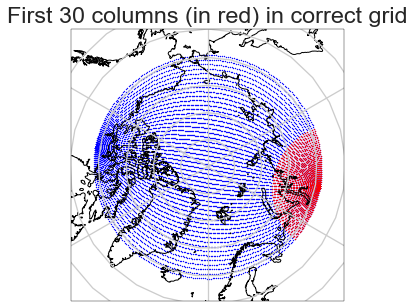

In [11]:
# Now we do get entire columns by slicing the second dimension
ax = polar_axis() 
ax.scatter(lon_correct, lat_correct, label='full grid',
            transform=ccrs.PlateCarree(), s=1.0, c='b')
ax.scatter(lon_correct[:, :30], lat_correct[:, :30], label='sliced columns',
            transform=ccrs.PlateCarree(), s=1.0, c='r')
plt.title('First 30 columns (in red) in correct grid')

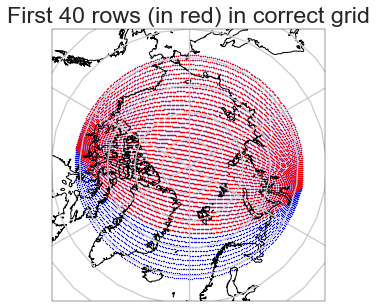

In [12]:
# Also check rows
# Without np.flipud(), the row order will be wrong.
ax = polar_axis() 
ax.scatter(lon_correct, lat_correct,label='full grid',
            transform=ccrs.PlateCarree(), s=1.0, c='b')
ax.scatter(lon_correct[:40, :], lat_correct[:40, :], label='sliced rows',
            transform=ccrs.PlateCarree(), s=1.0, c='r')
plt.title('First 40 rows (in red) in correct grid')

In [13]:
# also correct the source data layout
data_raw = ds_in['sic'].values
data_correct = np.r_[data_raw[175:, :180], 
                     np.flipud(np.fliplr(data_raw[175:, 180:]))]

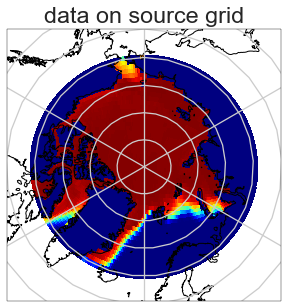

In [14]:
# Now the data can be plotted correctly. No missing seam.
ax = polar_axis() 
ax.pcolormesh(lon_correct, lat_correct, data_correct, 
              transform=ccrs.PlateCarree(), cmap='jet')
plt.title('data on source grid')

# Regrid the corrected data

In [15]:
# being lazy here, just use dict
grid_in_correct = {'lon': lon_correct, 'lat': lat_correct}

In [16]:
# Try different regridding options
regridder = xesmf.Regridder(grid_in_correct, ds_target, 'bilinear', reuse_weights=False)
data_out = regridder(data_correct)

Create weight file: bilinear_50x180_304x448.nc


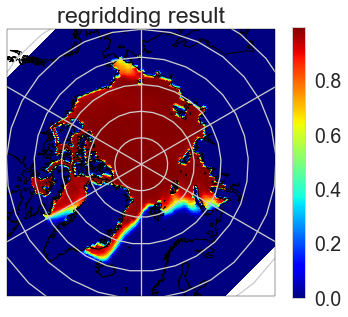

In [17]:
ax = polar_axis() 
im = ax.pcolormesh(ds_target['lon'], ds_target['lat'], data_out, 
              transform=ccrs.PlateCarree(), cmap='jet')
plt.colorbar(im)
plt.title('regridding result')